In [1]:
import sys 

In [1]:
cd '/srv/share3/hagrawal9/project/habitat/habitat-api/'

/coc/pskynet3/hagrawal9/project/habitat/habitat-api


In [2]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps, fog_of_war
from habitat.utils.visualizations.utils import observations_to_image

from rearrangement.utils.planner import (
    compute_traversable_map,
    compute_distance_using_fmm,
    find_shortest_path_for_multiple_objects,
    compute_distance_mat_using_fmm,
    compute_distance_mat_using_navmesh
)
from rearrangement.utils.visualization import (
    get_top_down_map
)
from rearrangement.utils.geometry import (
     geodesic_distance
)
from rearrangement.utils.geometry import get_polar_angle


In [3]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [4]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [5]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [6]:
config.defrost()
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.freeze()

In [8]:
def make_video_cv2(
    observations, cross_hair=None, prefix="", open_vid=True, fps=60
):
    sensor_keys = list(observations[0])
    videodims = observations[0][sensor_keys[0]].shape
    videodims = (videodims[1], videodims[0])  # flip to w,h order
    print(videodims)
    video_file = output_path + prefix + ".mp4"
    print("Encoding the video: %s " % video_file)
    writer = vut.get_fast_video_writer(video_file, fps=fps)
    for ob in observations:
        # If in RGB/RGBA format, remove the alpha channel
        rgb_im_1st_person = cv2.cvtColor(ob["rgb"], cv2.COLOR_RGBA2RGB)
        if cross_hair is not None:
            rgb_im_1st_person[
                cross_hair[0] - 2 : cross_hair[0] + 2,
                cross_hair[1] - 2 : cross_hair[1] + 2,
            ] = [255, 0, 0]

        if rgb_im_1st_person.shape[:2] != videodims:
            rgb_im_1st_person = cv2.resize(
                rgb_im_1st_person, videodims, interpolation=cv2.INTER_AREA
            )
        # write the 1st person observation to video
        writer.append_data(rgb_im_1st_person)
    writer.close()

    if open_vid:
        print("Displaying video")
        vut.display_video(video_file)


In [9]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [10]:
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument(
        "--no-make-video", dest="make_video", action="store_false"
    )
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    make_video = args.make_video
else:
    show_video = False
    make_video = False
    display = False

In [11]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)
fog_of_war_mask = None

2020-10-13 23:42:16,520 Initializing dataset RearrangementDataset-v0
2020-10-13 23:42:19,836 initializing sim RearrangementSim-v0
2020-10-13 23:42:25,302 Initializing task RearrangementTask-v0


In [166]:
obs = env.reset()
metrics = env.get_metrics()

explored_mask = None
visible_mask = None

env._sim.recompute_navmesh(env._sim.pathfinder, env._sim.navmesh_settings, True)
print(env.current_episode.episode_id)
agent_pos = env._sim.get_agent(0).get_state().position

for objid in env._sim.get_existing_object_ids():
    if objid != env._sim.agent_object_id:
        episode_obj_id = env._task.sim_object_to_objid_mapping[objid]
        dist = geodesic_distance(env._sim.pathfinder, agent_pos, env.current_episode.objects[episode_obj_id].position)
        if dist == np.inf:
            print("Voila!!")
            

411


In [290]:
# obs = env.step(1)
obs = env.step(1)

In [55]:
obs = env.step(2)

In [288]:
obs = env.step(3)

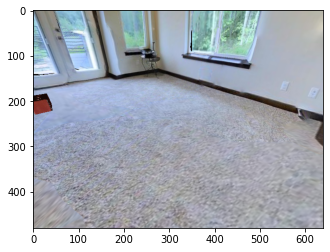

In [289]:
plt.imshow(obs['rgb'])
plt.show()

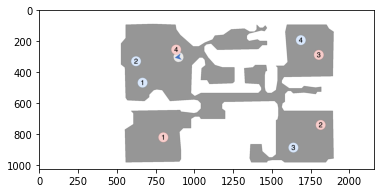

In [270]:
metrics = env.get_metrics()

top_down_map, fog_of_war_mask = get_top_down_map(
    env, env._task._simple_pathfinder, ignore_objects=True, fog_of_war_mask=fog_of_war_mask, draw_fow=True, 
    draw_agent=True, draw_object_start_pos=True, draw_object_final_pos=True, draw_object_curr_pos=True
)


plt.imshow(top_down_map)
plt.show()

In [290]:
def reveal_map(env, visible_mask, explored_mask):
    agent_position = env._sim.get_agent_state().position
    agent_rotation = get_polar_angle(env._sim)
    top_down_map = maps.get_topdown_map(
        env._task._simple_pathfinder,
        env._sim.get_agent(0).state.position[1],
        1024
    )

    a_y, a_x = maps.to_grid(
        agent_position[2],
        agent_position[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    if not isinstance(visible_mask, np.ndarray):
        print("coming here!")
        visible_mask = np.zeros_like(top_down_map)
        # explored_mask = np.zeros_like(top_down_map)

    visible_mask = fog_of_war.reveal_fog_of_war(
        top_down_map,
        visible_mask,
        np.array([a_y, a_x]),
        agent_rotation,
        fov = 90,
        max_line_len = 499
    )

#     explored_mask = fog_of_war.reveal_fog_of_war(
#         top_down_map,
#         explored_mask,
#         np.array([a_y, a_x]),
#         agent_rotation,
#         fov = 90,
#         max_line_len = 500
#     )

#     obstacles_mask = explored_mask - visible_mask
    
    # return top_down_map, obstacles_mask, explored_mask, visible_mask
    return top_down_map, visible_mask

In [291]:
top_down_map, visible_mask = reveal_map(env, visible_mask, explored_mask)
obstacles_mask = np.copy(visible_mask)
obstacles_mask[obstacles_mask <= 1] = 0
obstacles_mask[obstacles_mask >1] = 1 

In [292]:
np.unique(obstacles_mask), np.unique(explored_mask), np.unique(visible_mask)

(array([0, 1], dtype=uint8),
 array([None], dtype=object),
 array([0, 1, 2], dtype=uint8))

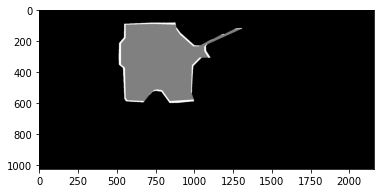

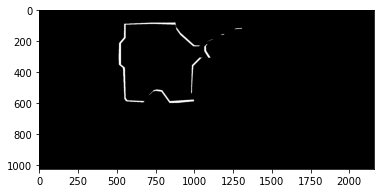

In [293]:
plt.imshow(visible_mask, cmap="gray")
plt.show()
# plt.imshow(explored_mask, cmap="gray")
# plt.show()
plt.imshow(obstacles_mask, cmap="gray")
plt.show()
# plt.imshow(top_down_map)
# plt.show()

In [294]:
fog_of_war_mask = (obstacles_mask * 255/np.max(obstacles_mask)).astype(np.uint8)
fog_of_war_mask = np.invert(fog_of_war_mask)

[  0 255]


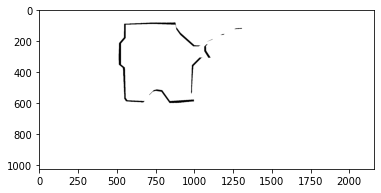

In [295]:
plt.imshow(fog_of_war_mask, cmap="gray")
print(np.unique(fog_of_war_mask))

In [296]:
episode = env.current_episode
agent_position = env._sim.get_agent_state().position
a_y, a_x = maps.to_grid(
    agent_position[2],
    agent_position[0],
    top_down_map.shape[0:2],
    sim=env._sim,
)

object_positions = [obj.position for obj in episode.objects]
goal_positions = [obj.position for obj in episode.goals]

grid_object_positions = []
grid_goal_positions = []

for i, obj_pos in enumerate(object_positions):
    tdm_pos = maps.to_grid(
        obj_pos[2],
        obj_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )
    grid_object_positions.append(tdm_pos)

# draw the objectgoal positions.
for i, goal_pos in enumerate(goal_positions):
    tdm_pos = maps.to_grid(
        goal_pos[2],
        goal_pos[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    grid_goal_positions.append(tdm_pos)


In [297]:
fog_of_war_mask = fog_of_war_mask / np.max(fog_of_war_mask)
dmat = compute_distance_mat_using_fmm(fog_of_war_mask, [a_y, a_x], grid_object_positions, grid_goal_positions)

In [298]:
dmap = compute_distance_using_fmm(fog_of_war_mask, [a_y, a_x])

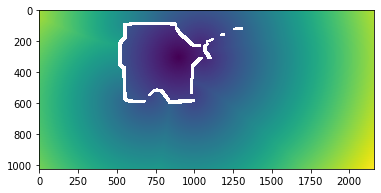

In [299]:
plt.imshow(dmap)

array([  0, 255], dtype=uint8)

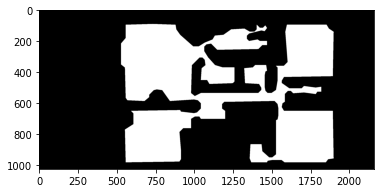

In [215]:
gs_tdmap = np.copy(top_down_map[:, :])
gs_tdmap[gs_tdmap < 1] = 0
gs_tdmap[gs_tdmap >= 1] = 255
plt.imshow(gs_tdmap, cmap="gray")
np.unique(gs_tdmap)

In [63]:
gs_tdmap = gs_tdmap / np.max(gs_tdmap)
dmat = compute_distance_mat_using_fmm(gs_tdmap, [a_y, a_x], grid_object_positions, grid_goal_positions)
dmat, dmat.shape

(array([[   0.        ,  580.87443947,  693.90799686,  600.48165718,
          352.64269297,  256.02021459,  109.03414187,  649.780442  ,
           48.99345483],
        [   0.        ,    0.        ,  163.75043226,  902.7748104 ,
          361.34459249,  328.54142812,  474.15808509,  152.93213707,
          597.78276262],
        [   0.        ,  163.75043226,    0.        ,  942.26282868,
          520.04780692,  438.91564277,  593.49291504,  276.44067426,
          718.63151419],
        [   0.        ,  902.77133565,  942.20398593,    0.        ,
          879.46373249,  652.64895506,  640.20714018, 1031.82810981,
          646.41454176],
        [   0.        ,  361.34459249,  520.04780692,  879.46373248,
            0.        ,  241.22813971,  259.01799412,  354.67991759,
          340.79196002],
        [   0.        ,  328.54142812,  438.91564277,  652.6508605 ,
          241.22813971,    0.        ,  155.48274511,  418.22183967,
          280.23000346],
        [   0.        

In [64]:
max_value = np.max(dmat[dmat!=np.inf]) 
dmat[dmat == np.inf] = max_value + 100
dmat /= max_value + 100

In [65]:
route, pickup_order = find_shortest_path_for_multiple_objects(dmat)

In [1]:
pickup_order

NameError: name 'pickup_order' is not defined

In [68]:
dmat

array([[0.        , 0.51321419, 0.6130816 , 0.53053756, 0.31156688,
        0.22619898, 0.09633385, 0.57409402, 0.0432867 ],
       [0.        , 0.        , 0.14467678, 0.79761961, 0.31925518,
        0.29027293, 0.41892816, 0.1351186 , 0.52815303],
       [0.        , 0.14467678, 0.        , 0.83250806, 0.45947264,
        0.38779075, 0.52436287, 0.24424087, 0.63492532],
       [0.        , 0.79761654, 0.83245607, 0.        , 0.7770238 ,
        0.57662841, 0.56563582, 0.91164078, 0.57112018],
       [0.        , 0.31925518, 0.45947264, 0.7770238 , 0.        ,
        0.21312989, 0.22884758, 0.3133668 , 0.30109652],
       [0.        , 0.29027293, 0.38779075, 0.57663009, 0.21312989,
        0.        , 0.13737212, 0.36950736, 0.24758882],
       [0.        , 0.41892816, 0.52436287, 0.56563586, 0.22884758,
        0.13737212, 0.        , 0.47807426, 0.11081118],
       [0.        , 0.1351186 , 0.24424087, 0.911648  , 0.3133668 ,
        0.36950736, 0.47807426, 0.        , 0.57966436],


In [72]:
np.unique(gs_tdmap)

array([0., 1.])

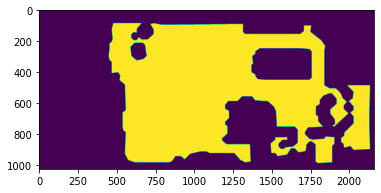

In [73]:
plt.imshow(gs_tdmap)